<a href="https://colab.research.google.com/github/E-crls/Rede-neural-do-zero/blob/main/Rede_neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Aviso: O algoritmo não foi implementado, apenas construído

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.ToTensor() #definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data',download=True, train=True, transform=transform) #Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data', download=True, train=False, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) #cria um buffer para pegar os dados por partes

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw



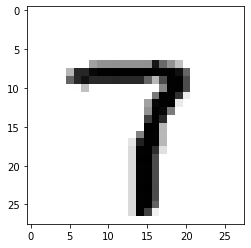

In [3]:
dataiter = iter(trainloader)
imagens, etiquetas = dataiter.next()
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [4]:
print(imagens[0].shape) #para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape)#para verificar as dimensões do tensor de cada etiqueta



torch.Size([1, 28, 28])
torch.Size([])


#Modelos 'Modelo' e 'treino' a seguir foram baseador no inceptionv3

In [5]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neuronios que se ligam 128
    self.linear2 = nn.Linear(128,64) # camada interna 1, 128 neuronios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neuronios que se ligam a 10
    #para a camada de saida não é necessário definir nada pois só precisamor pegar o output da camada interna 2
  
  def forward(self, X):
    X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
    X = self.linear3(X) # funções de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
    return F.log_softmax(X, dim=1) #dados utilizados para calcular a perda

In [7]:
def treino(modelo, trainloader, device):
  
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #define a politica de atualização dos pesos e da bias
  inicio = time() # timer para sabermos quanto tempo levou o treino

  criterio = nn.NLLLoss # definindo o criterio para calcular a perda
  EPOCHS = 10 # numero de epochs que o algoritmo rodará
  modelo.train() # ativando o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada=0 # inicialização da perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casa para ficarem compativeis com a
      otimizador.zero_grad() #zerando gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

      perda_instantanea.backward()# back propagation a partir da perda

      otimizador.step() # atualizando os pesos e a bias

      perda_acumulada += perda_instantanea.item() # atualização da perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino (em minutos) =", (time()-inicio)/60)

In [8]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala logaritimica
      
      ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte o tensor em um número, no caso,o número que o modelo previu como correto
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
        conta_corretas +=1
      conta_todas += 1
  print("Total de imagens testadas = ", conta_todas)
  print("\nPrecisão do modelo = {}%".format(conta_corretas*100/conta_todas))


#Leitura do modelo

teste se o cuda esta ativo

In [9]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)